<!DOCTYPE html>
<html lang="fr">
<head>
    <meta charset="UTF-8">
    <title>Analyse de Trajectoires de Tracking</title>
    <style>
        body {
            font-family: Arial, sans-serif;
        }
        h1 {
            color: skyblue;
            font-size: 24px;
        }
        p, li {
            font-size: 16px;
        }
        .green-text{
            color: DarkSeaGreen;
        }
    </style>
</head>
<body>
    <h1>Analyse de Trajectoires de Tracking</h1>
    <p>Ce code d'analyse permet de traiter les données issues du tracking pour extraire et étudier statistiquement les trajectoires pertinentes. Le processus est structuré comme suit :</p>
    <ol>
        <li><strong class="green-text">Récupération des trajectoires :</strong> Collecte de toutes les trajectoires issues des différentes manipulations.</li>
        <li><strong class="green-text">Pré-analyse :</strong> Examen initial des trajectoires pour déterminer celles à conserver pour l'analyse approfondie.</li>
        <li><strong class="green-text">Analyse statistique :</strong> Application de méthodes statistiques aux trajectoires conservées. Les données peuvent être séparées en deux populations pour un traitement spécifique si nécessaire.</li>
    </ol>
    <p>L'analyse se concentre sur les paramètres suivants :</p>
    <ul>
        <li>Angle entre les directions successives d'une particule entre chaque intervalle de temps.</li>
        <li>Vitesses moyennes et instantanées des particules.</li>
        <li>Variation de la vitesse en fonction du temps d'incubation.</li>
        <li>Effet potentiel de la densité de cellules sur la motilité.</li>
    </ul>
</body>
</html>


##
<center><span style="color: seagreen; font-size: 50px; font-style: bold">Chargement et préparation des données.</span></center>
<span style="color: skyblue; font-size: 20px; font-style: bold">Chargement des librairies.</span>

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  1 12:46:56 2023.

@author: souchaud
"""

import os
import time
import math
import pandas as pd
import numpy as np
# import imageio
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colormaps
from cycler import cycler
import trackpy as tp
import functions_analyze as lib
import warnings
import importlib
from colorama import init
from typing import List, Optional, Union, Any, Dict, Tuple

# Reload custom library
importlib.reload(lib)

# Initialize colorama
init(autoreset=True)

# Suppress specific warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

# Set default matplotlib style
plt.style.use('default')

<span style="color: skyblue; font-size: 20px; font-style: bold">Paramètres de graphs.</span>

In [3]:
# Update matplotlib parameters
plt.rcParams.update({
    "figure.facecolor": (0.12, 0.12, 0.12, 1),
    "axes.facecolor": (0.12, 0.12, 0.12, 1),
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "text.color": "white",
    "axes.titlesize": 16,
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "axes.labelweight": "medium",
    "legend.fontsize": 12,
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "font.size": 12,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "axes.prop_cycle": cycler(color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]),
})


##
<span style="color: skyblue; font-size: 20px; font-style: bold">Initialisation des variables et constantes de travail..</span>

In [4]:
# Set initial time
INITIAL_TIME = time.time()

# Experiment parameters
TIME_FRAME = 15
SIZE_PIX = 0.637
FPS = 1 / TIME_FRAME

# File to study
file_name = 'filtered_final'
N_FRAME_MIN_STUDY = 200

# Study parameters
ROLLING_MEAN = False
PIXELISATION = False
TIME_FRAME_STUDY = False
DRIFT = False

# Plot parameters
IMG_TYPE = 'svg'
ALPHA = 0.5
LINEWIDTH = 0.1
COLOR_SUP = 'blue'
COLOR_INF = 'red'
color_sup_inf = (COLOR_SUP, COLOR_INF)

##
<span style="color: skyblue; font-size: 20px; font-style: bold">Définition des path et dossiers de travails / enregistrements.</span>

<span style="color: skyblue; font-size: 20px; font-style: bold">Conditions des manips étudiées.</span>

<span style="color: skyblue; font-size: 20px; font-style: bold">Défintions et créations des différents dossiers d'enregistrements.</span>

In [5]:
# General paths
GENERAL_PATH = '/Users/souchaud/Desktop/Analyses/'
GENERAL_PATH_PICTURES = '/Users/souchaud/Desktop/A_analyser/'

# Condition
CONDITION_simple = 'CytoOne_SorC_10x'
CONDITION = f'{CONDITION_simple}_results_tracking'

# Get list of experiments
PATHWAY_EXPERIMENT = [f for f in os.listdir(GENERAL_PATH + CONDITION)
                      if os.path.isdir(os.path.join(GENERAL_PATH + CONDITION, f))]

# Update experiment paths
PATHWAY_EXPERIMENT = [os.path.join(GENERAL_PATH, CONDITION, elem, 'mosaic')
                      for elem in PATHWAY_EXPERIMENT]

# Path to save pictures
path_save_pic = os.path.join(GENERAL_PATH, f'résultats_{CONDITION}_All')

# Create directory if it doesn't exist
os.makedirs(path_save_pic, exist_ok=True)
os.chdir(path_save_pic)


##
<center><span style="color: Crimson; font-size: 30px; font-style: bold">Lecture des données expériementales.</span></center>

<span style="color: skyblue; font-size: 20px">On décide de travailler que sur un certain nombre de frame. Ici je décide de travailler sur les 340 première frames pour normaliser les expériences. 
Donc la cellules doit être suivi sur N_MIN_STUDY sur les 340 premières frames. </span>

<span style="color: skyblue; font-size: 20px">Application de fonctions pour moyenne flissante et pixelisation et étude d'une frame sur x </span>

In [6]:
# Read HDF5 data
importlib.reload(lib)
DATA = lib.read_hdf5_all(
    pathway_experiment=PATHWAY_EXPERIMENT,
    name_file=file_name,
    nbr_frame_min=N_FRAME_MIN_STUDY,
    condition=CONDITION,
    drift=DRIFT,
    search_range=20,
    memory=5
)

# Sort DATA by 'frame'
DATA.sort_values(by='frame', inplace=True)

# Filter DATA
print("Nombre de particules avant tri: ", DATA['particle'].nunique())
DATA = DATA[DATA['frame'] < 340]

# Keep particles with sufficient frames
DATA = DATA.groupby('particle').filter(lambda x: len(x) >= N_FRAME_MIN_STUDY)
print("Nombre de particules après tri: ", DATA['particle'].nunique())

# Apply optional data transformations
if ROLLING_MEAN:
    DATA = lib.rolling_mean(datas=DATA, roll=3)
if PIXELISATION:
    DATA = lib.pixelisation(datas=DATA, size_pix=SIZE_PIX)
if TIME_FRAME_STUDY:
    DATA, TIME_FRAME = lib.keep_nth_image(traj=DATA, n=N_FRAME_MIN_STUDY, time_frame=TIME_FRAME)

# Calculate instant velocities
DATA['time (min)'] = DATA['frame'] * TIME_FRAME / 60
DATA = lib.vit_instant_new(traj=DATA, lag_time=TIME_FRAME, pix_size=SIZE_PIX, triage=1)


['/Users/souchaud/Desktop/Analyses/CytoOne_SorC_10x_results_tracking/2024_10_16_ASMOT192_AX3_2024_P3_10x_CytoOne_SorC_1410-10h30DansSorCpuisHL5le1510a10h10_1610_16h00/mosaic/filtered_final.hdf5']
ASMOT192  :  105
['/Users/souchaud/Desktop/Analyses/CytoOne_SorC_10x_results_tracking/2024_11_07_ASMOT202_AX3_2024_P2_10x_CytoOne_SorC_0611-10h00-0711-10h30/mosaic/filtered_final.hdf5']
ASMOT202  :  217
No HDF5 files found in /Users/souchaud/Desktop/Analyses/CytoOne_SorC_10x_results_tracking/2024_10_17_ASMOT193_AX3_2024_P3_10x_CytoOne_SorC_1410-10h30DansSorCpuisHL5le1510a10h10_1710_11h10/mosaic. Skipping to next directory.
['/Users/souchaud/Desktop/Analyses/CytoOne_SorC_10x_results_tracking/2024_11_07_ASMOT205_AX3_2024_P2_10x_CytoOne_SorC_0611-10h00-0711-15h15/mosaic/filtered_final.hdf5']
ASMOT205  :  534
No HDF5 files found in /Users/souchaud/Desktop/Analyses/CytoOne_SorC_10x_results_tracking/2024_11_07_ASMOT210_AX3_2024_P5_10x_CytoOne_SorC_1311-11h05-1311-17h20/mosaic. Skipping to next direc

###
<center><span style="color: skyblue; font-size: 20px"> Mean Mass and size plot </span></center>

In [ ]:
# Plot Mean Mass and Size per Manipulation
def plot_mean_mass_size(DATA, path_save_pic, IMG_TYPE):
    manips = DATA['experiment'].unique()
    num_manips = len(manips)
    fig = plt.figure(figsize=(16, 6 * num_manips))
    gs = gridspec.GridSpec(num_manips, 3, fig)
    colors = ['skyblue', 'lightgreen', 'salmon']
    for i, manip in enumerate(manips):
        data_manip = DATA[DATA['experiment'] == manip]
        mass_means = data_manip.groupby('particle')['mass'].mean()
        size_means = data_manip.groupby('particle')['size'].mean()
        filtered_data = data_manip[data_manip['frame'] == 0]

        ax1 = fig.add_subplot(gs[i, 0])
        ax1.hist(mass_means, bins=100, color=colors[0], density=True)
        ax1.set_title(f"Mean mass of particles for {manip}")
        ax1.set_xlabel("Mean mass")
        ax1.set_ylabel("Density")

        ax2 = fig.add_subplot(gs[i, 1])
        ax2.hist(size_means, bins=100, color=colors[1], density=True)
        ax2.set_title(f"Mean size of particles for {manip}")
        ax2.set_xlabel("Mean size")
        ax2.set_ylabel("Density")

        ax3 = fig.add_subplot(gs[i, 2])
        ax3.scatter(filtered_data['size'], filtered_data['mass'], c="#d62728", edgecolors="#d62728", alpha=0.7)
        ax3.set_title(f"Mass vs. Size at frame 0 for {manip}")
        ax3.set_xlabel("Size")
        ax3.set_ylabel("Mass")
        ax3.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(path_save_pic, f"Mean_Mass_Size_manip.{IMG_TYPE}"), format=IMG_TYPE)

plot_mean_mass_size(DATA, path_save_pic, IMG_TYPE)


###
<center><span style="color: skyblue; font-size: 20px"> plot total path for each partciel in each experiment (histograms) </span></center>

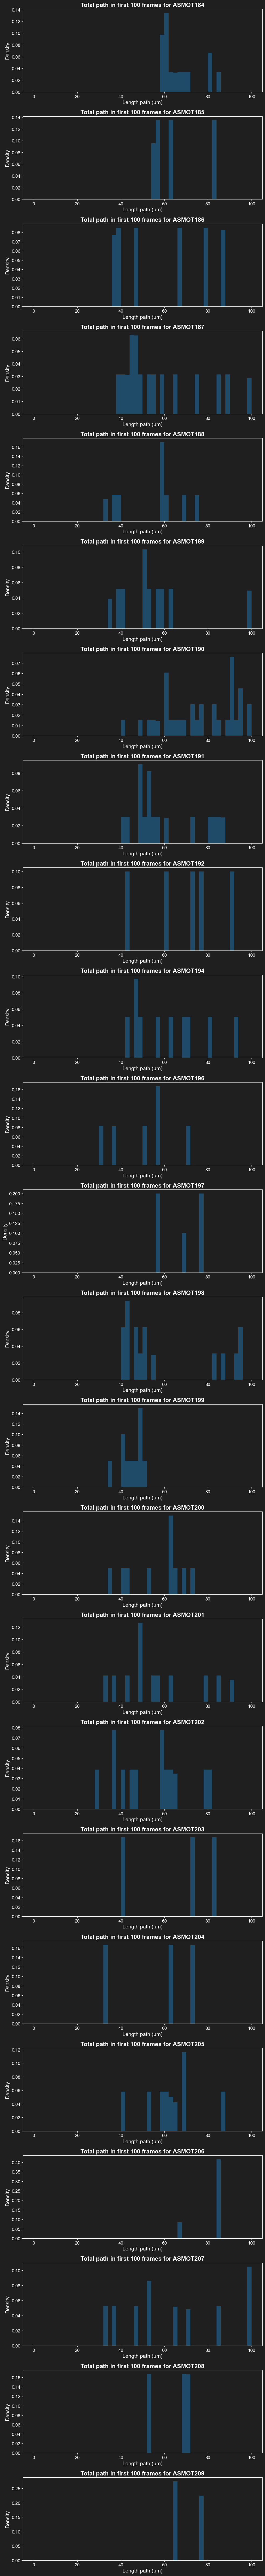

In [8]:
# Calculate total path for the first N frames
path_data = lib.calculate_total_path_first_frames(DATA, first_n_frames=100)

# Plot Total Path in First 100 Frames per Experiment
def plot_total_path(path_data):
    grouped = path_data.groupby('experiment')
    n_experiments = len(grouped)
    fig, axes = plt.subplots(nrows=n_experiments, figsize=(10, 4 * n_experiments))
    axes = axes if n_experiments > 1 else [axes]
    for (experiment, group), ax in zip(grouped, axes):
        ax.hist(group['total_path_first_n'], bins=50, range=[0, 100], density=True, alpha=0.5)
        ax.set_title(f"Total path in first 100 frames for {experiment}")
        ax.set_xlabel('Length path (μm)')
        ax.set_ylabel('Density')
    plt.tight_layout()
    plt.savefig(os.path.join(path_save_pic, f"Total path in first 100 frames.{IMG_TYPE}"), format=IMG_TYPE)
    plt.show()

plot_total_path(path_data)

###
<center><span style="color: skyblue; font-size: 20px"> Creation des traj centrées / distance cumulée / IMSD </span></center>


In [9]:
# Center trajectories
DATA.reset_index(inplace=True)
DATA = lib.center(traj=DATA)

print(f"\n\nTemps de préparation des données pour {CONDITION}: {time.time() - INITIAL_TIME} sec\n\n")

# Calculate total and cumulative displacement
DATA, start_end = lib.length_displacement(traj=DATA, size_pix=SIZE_PIX)

# Compute MSD and cutoff
DATA2 = DATA.copy()
DATA2['frame'] = pd.factorize(DATA2['frame'])[0]
IMSD = tp.imsd(traj=DATA2, mpp=SIZE_PIX, fps=FPS, max_lagtime=200, statistic='msd')



Temps de préparation des données pour CytoOne_SorC_10x_results_tracking: 15.291376829147339 sec




###
<center><span style="color: skyblue; font-size: 20px"> Premier fit pour exclure certaines traj </span></center>

In [ ]:
# Trajectory clustering with fit and defining a cutoff
LAG_TIME_FIT = 5
importlib.reload(lib)
COEF_INF, COEF_SUP, PART_COEF_INF, PART_COEF_SUP, CUTOFF = lib.traj_clustering_with_fit_cutoff(
    DATA2, imsd=IMSD, hist=True, lag_time_fit=LAG_TIME_FIT, micronperpixel=SIZE_PIX,
    fps=FPS, binsize=250, peak_height=50, peak_width=1, save=True, pathway_fig=path_save_pic,
    name='all_experiment_autocorr', img_type=IMG_TYPE, plot=True, color_sup_inf=color_sup_inf,
    cutoff_default=0.30
)

# Keep only particles above cutoff
DATA = DATA[DATA['particle'].isin(PART_COEF_SUP)]

###
<center><span style="color: skyblue; font-size: 20px"> définitions des temps de manip </span></center>

In [11]:
conditions_to_values = {
    'ASMOT184': 0, 'ASMOT185': 0, 'ASMOT186': 0, 'ASMOT187': 24.00,
    'ASMOT188': 26.50, 'ASMOT189': 30.00, 'ASMOT190': 47.75, 'ASMOT191': 51.33,
    'ASMOT192': 53.50, 'ASMOT193': 48.67, 'ASMOT194': 50.17, 'ASMOT195': 53.00,
    'ASMOT196': 72.92, 'ASMOT197': 74.67, 'ASMOT198': 0.00, 'AMOT199': 4.00,
    'ASMOT200': 5.50, 'ASMOT201': 23.00, 'ASMOT202': 24.50, 'ASMOT203': 26.33,
    'ASMOT204': 27.83, 'ASMOT205': 29.25, 'ASMOT206': 47.00, 'ASMOT207': 1.00,
    'ASMOT208': 1.67, 'ASMOT209': 4.92,
}
DATA['time to incubation (hours)'] = DATA['experiment'].map(conditions_to_values).fillna(0.0)

# Compute sums of displacements
sums_df = (
    DATA.groupby(['experiment', 'particle'])['displacement [pix]']
    .apply(lambda x: x.head(200).sum())
    .reset_index(name='displacement_sum')
)

# Compute medians and extract incubation times
medians = DATA.groupby('experiment')['VitInst [um/min]'].median()
# exp_hours = (
#     DATA[DATA['time to incubation (hours)'] != 0]
#     .groupby('experiment')
#     .agg({'time to incubation (hours)': 'first', 'particle': 'nunique'})
#     .reset_index()
#     .rename(columns={'particle': 'number of particles'})
# )
exp_hours = (
    DATA.groupby('experiment')
    .agg({'time to incubation (hours)': 'first', 'particle': 'nunique'})
    .reset_index()
    .rename(columns={'particle': 'number of particles'})
)

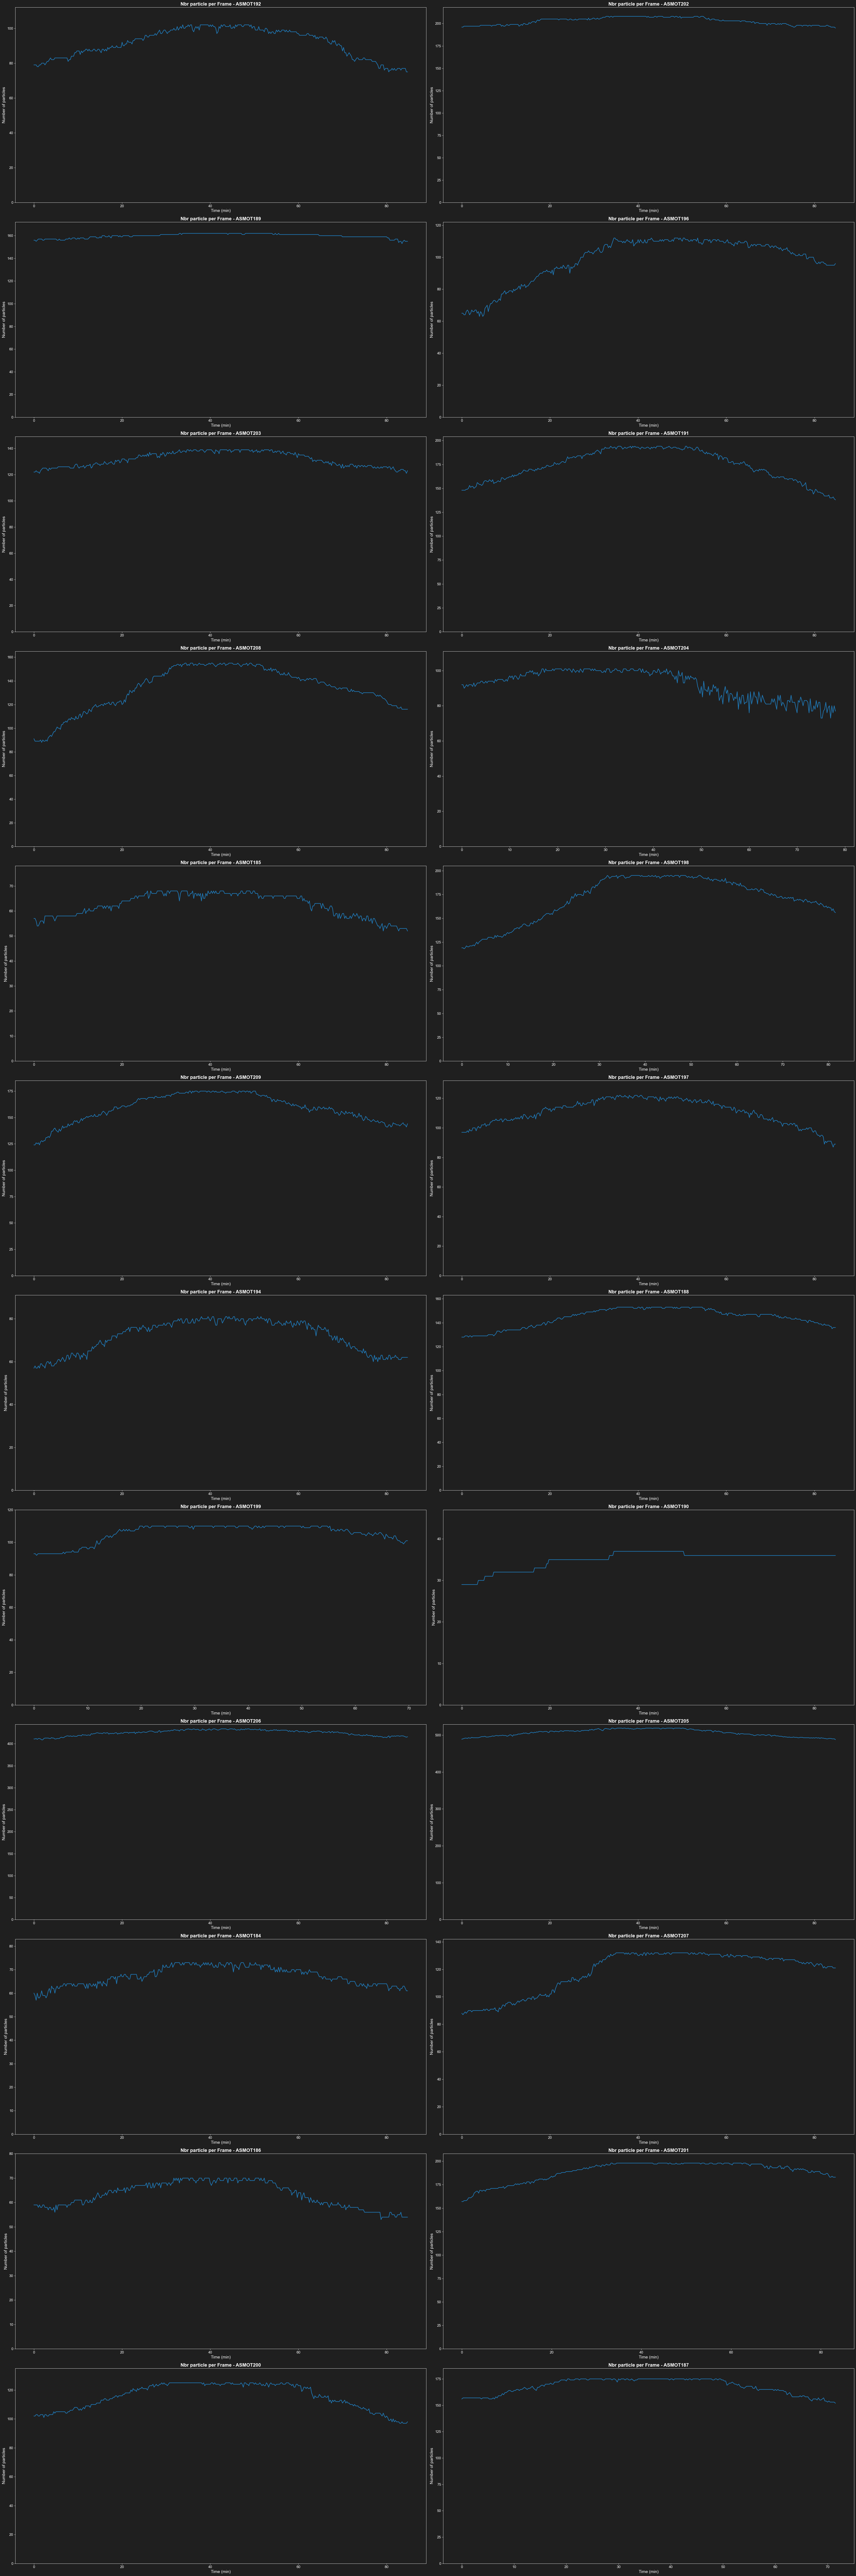

In [12]:
# Plot Number of Particles per Frame per Experiment
def plot_nbr_particles_per_frame(DATA, path_save_pic, IMG_TYPE):
    experiments = DATA['experiment'].unique()
    n_cols = 2
    n_rows = (len(experiments) + n_cols - 1) // n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20 * n_cols, 10 * n_rows))
    axs = axs.flatten()
    for i, exp in enumerate(experiments):
        nbr_part_per_frame = DATA[DATA['experiment'] == exp].groupby('time (min)')['particle'].nunique()
        ax = axs[i]
        ax.plot(nbr_part_per_frame.index, nbr_part_per_frame.values)
        ax.set_ylim([0, nbr_part_per_frame.max() + 10])
        ax.set_title(f'Nbr particle per Frame - {exp}')
        ax.set_xlabel('Time (min)')
        ax.set_ylabel('Number of particles')
    for ax in axs[len(experiments):]:
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(path_save_pic, f"Nbr_particle_per_Frame_manip_par_manip.{IMG_TYPE}"), format=IMG_TYPE)
    plt.show()

plot_nbr_particles_per_frame(DATA, path_save_pic, IMG_TYPE)

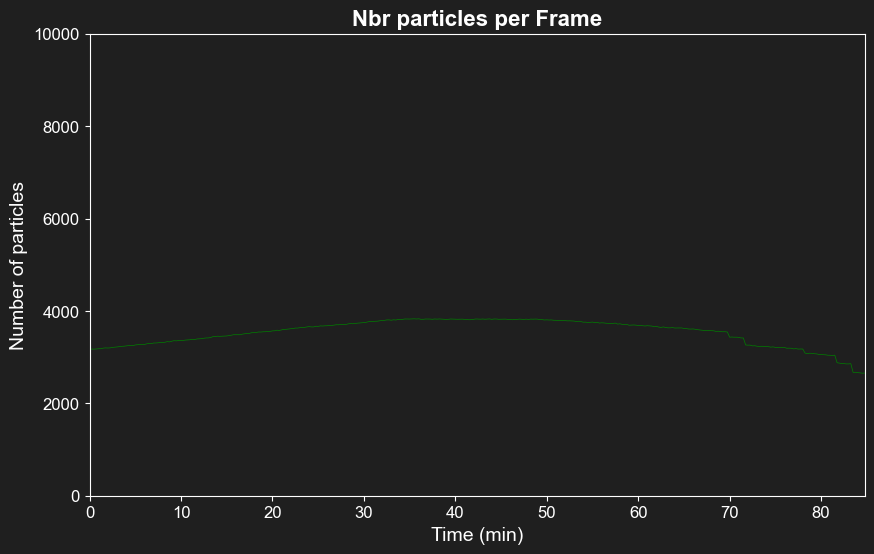

Figure saved at: /Users/souchaud/Desktop/Analyses/résultats_CytoOne_SorC_10x_results_tracking_All/Nbr_particles_per_Frame.svg


In [13]:
# Plot Number of Particles per Frame
nbr_part_per_frame = DATA.groupby('time (min)')['particle'].nunique()
lib.plot_datas(
    x_values=nbr_part_per_frame.index,
    y_values=nbr_part_per_frame.values,
    title='Nbr particles per Frame',
    x_label='Time (min)', y_label='Number of particles',
    x_lim=[0, nbr_part_per_frame.index.max()], y_lim=[0, 10000],
    save=True, path_save_pic=path_save_pic, img_type=IMG_TYPE
)

In [ ]:
# Plot Trajectories after Removing Suspicious Particles
fig, axis = plt.subplots(figsize=(12, 12), dpi=300)
axis.set_aspect('equal', 'box')
plt.title('Trajectories after removing suspicious particles', fontsize=16)
tp.plot_traj(DATA, label=False, ax=axis)
for line in axis.get_lines():
    line.set_linewidth(0.1)
plt.show()
fig.savefig(os.path.join(path_save_pic, f'Trajectories_after_removing_suspicious_particles.{IMG_TYPE}'),
            format=IMG_TYPE, dpi=300, bbox_inches='tight')

In [ ]:
# Plot Trajectories on Original Frames
def plot_trajectories_on_frames(DATA, path_save_pic, GENERAL_PATH_PICTURES, CONDITION_simple):
    image_path = os.path.join(GENERAL_PATH_PICTURES, f"{CONDITION_simple}_faits")
    plot_exp = DATA.groupby('experiment')
    num_experiments = len(plot_exp)
    num_cols = 2
    num_rows = (num_experiments + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 10))
    axes = axes.flatten()
    for ax, (exp_name, exp_data) in zip(axes, plot_exp):
        exp_directories = []
        for dirpath, dirnames, _ in os.walk(image_path):
            for dirname in dirnames:
                if exp_name in dirname:
                    full_path = os.path.join(dirpath, dirname)
                    exp_directories.append(full_path)
        if exp_directories:
            image_path_directory = os.path.join(exp_directories[0], 'mosaic', 'mosaic_total_0.tif')
            frame = imageio.imread(image_path_directory)
            ax.set_aspect('equal', 'box')
            ax.set_title(f'Trajectories for {exp_name}')
            tp.plot_traj(exp_data, superimpose=frame, label=False, ax=ax)
        else:
            print(f"No directory found for {exp_name}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(path_save_pic, 'trajectories_on_frame_all_experiment.pdf'), format='pdf')

plot_trajectories_on_frames(DATA, path_save_pic, GENERAL_PATH_PICTURES, CONDITION_simple)

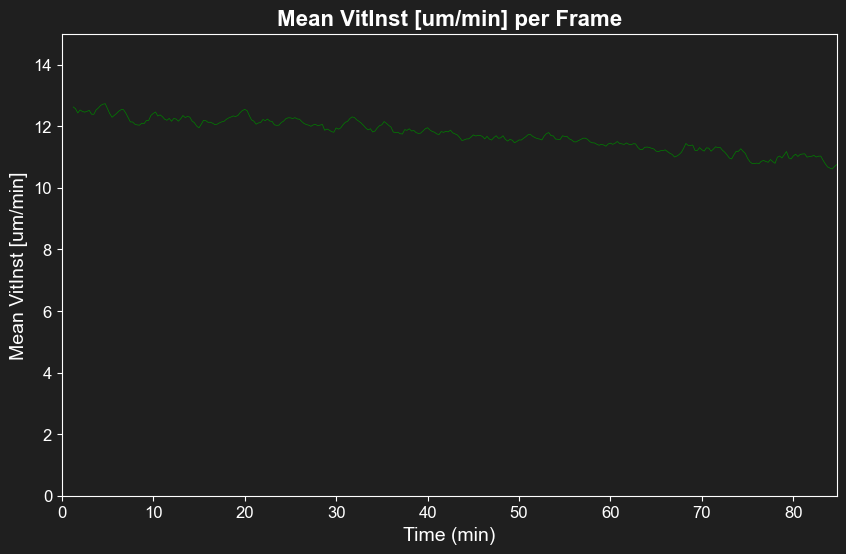

Figure saved at: /Users/souchaud/Desktop/Analyses/résultats_CytoOne_SorC_10x_results_tracking_All/Mean_VitInst_[um_min]_per_Frame.svg


In [16]:
# Plot Mean Instantaneous Speed per Frame
mean_VitInst_per_frame = DATA.groupby('time (min)')['VitInst [um/min]'].mean()
mean_VitInst_per_frame = mean_VitInst_per_frame.rolling(5).mean().dropna()

# Appel avec vérification du répertoire
lib.plot_datas(
    x_values=mean_VitInst_per_frame.index,
    y_values=mean_VitInst_per_frame.values,
    title='Mean VitInst [um/min] per Frame',
    x_label='Time (min)', y_label='Mean VitInst [um/min]',
    x_lim=[0, mean_VitInst_per_frame.index.max()], y_lim=[0, 15],
    save=True, path_save_pic=path_save_pic, img_type=IMG_TYPE
)

In [ ]:
# Recompute MSD
DATA2 = DATA.copy()
DATA2['frame'] = pd.factorize(DATA2['frame'])[0]
IMSD = tp.imsd(traj=DATA2, mpp=SIZE_PIX, fps=FPS, max_lagtime=200, statistic='msd')

lib.plot_msd(IMSD, fps=FPS, name="MSD of all frames vs lag time (s)",
             color_plot='red', save=True, pathway_saving=path_save_pic,
             alpha=0.5, linewidth=0.3, img_type=IMG_TYPE)

In [ ]:
# Recompute trajectory clustering with new cutoff
LAG_TIME_FIT = 5
COEF_INF, COEF_SUP, PART_COEF_INF, PART_COEF_SUP, CUTOFF = lib.traj_clustering_with_fit_cutoff(
    DATA2, imsd=IMSD, hist=True, lag_time_fit=LAG_TIME_FIT, micronperpixel=SIZE_PIX,
    fps=FPS, binsize=250, peak_height=50, peak_width=1, save=True, pathway_fig=path_save_pic,
    name='all_experiment_autocorr', img_type=IMG_TYPE, plot=True, color_sup_inf=color_sup_inf,
    cutoff_default=1.25
)

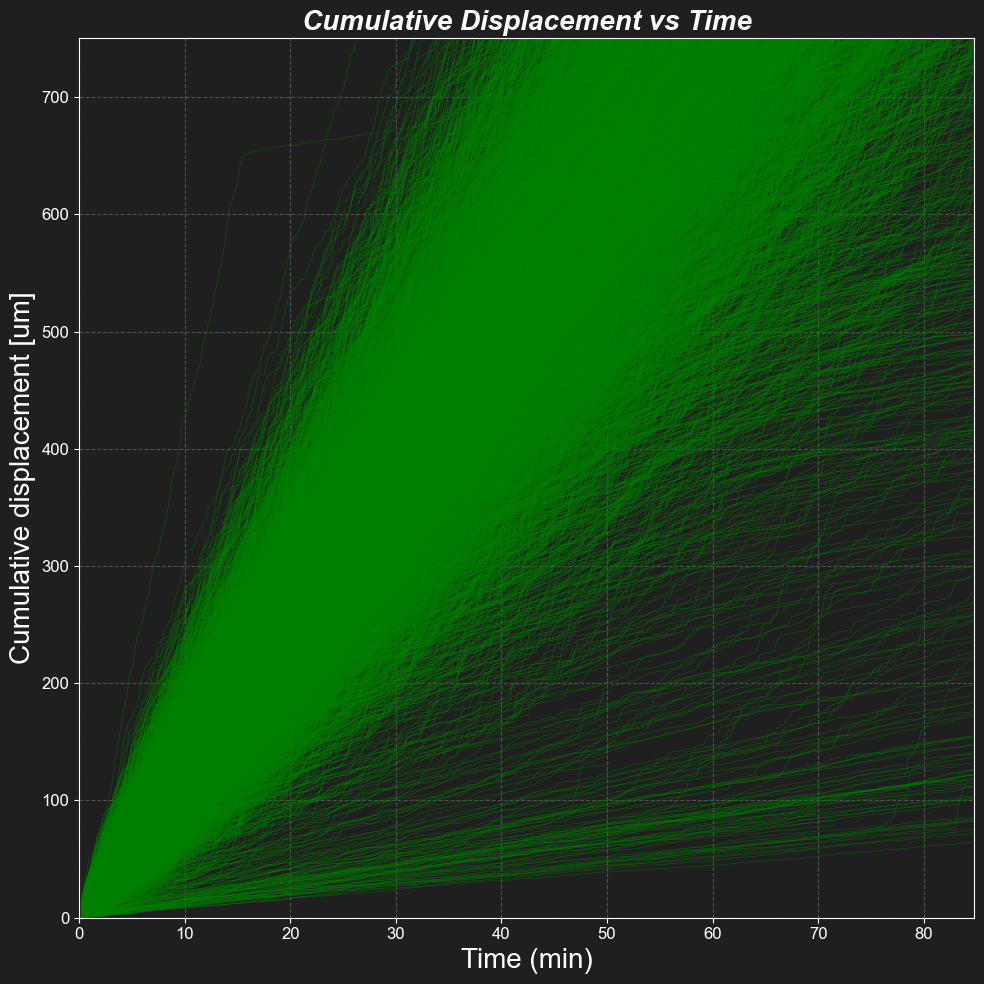

KeyError: 'start_end_distance [um]'

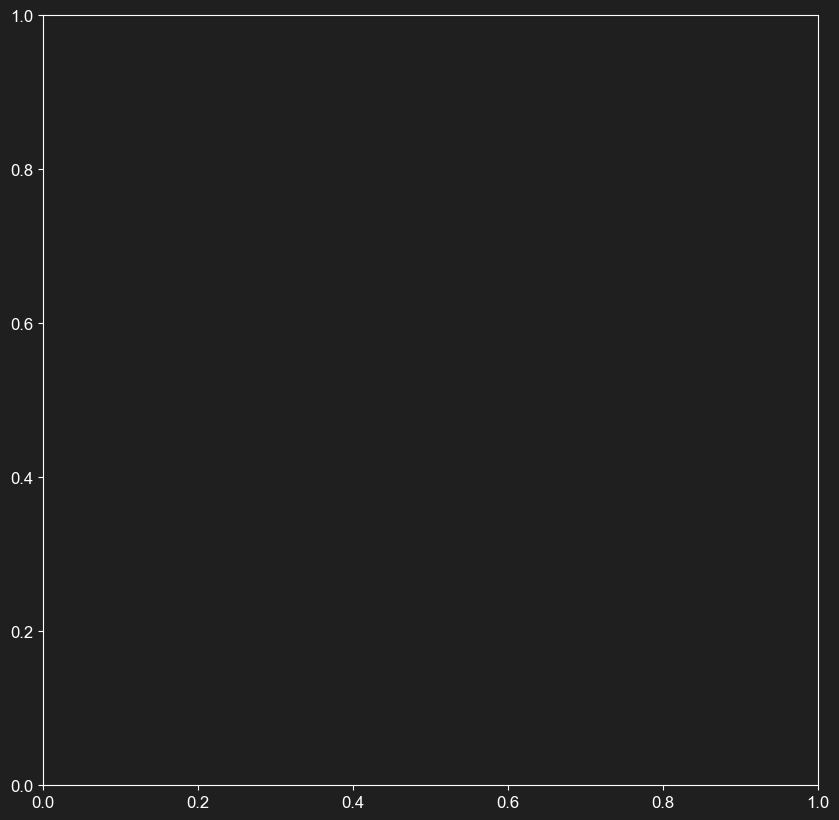

In [19]:
# Plot Displacement
lib.plot_displacement(
    DATA,
    start_end=start_end,
    alpha=0.5,
    linewidth=0.5,
    ylim=[0, 750],
    xlim=[0, DATA['time (min)'].max()],
    save=True,
    pathway_saving=path_save_pic,
    name='displacement start-end all',
    img_type=IMG_TYPE
)

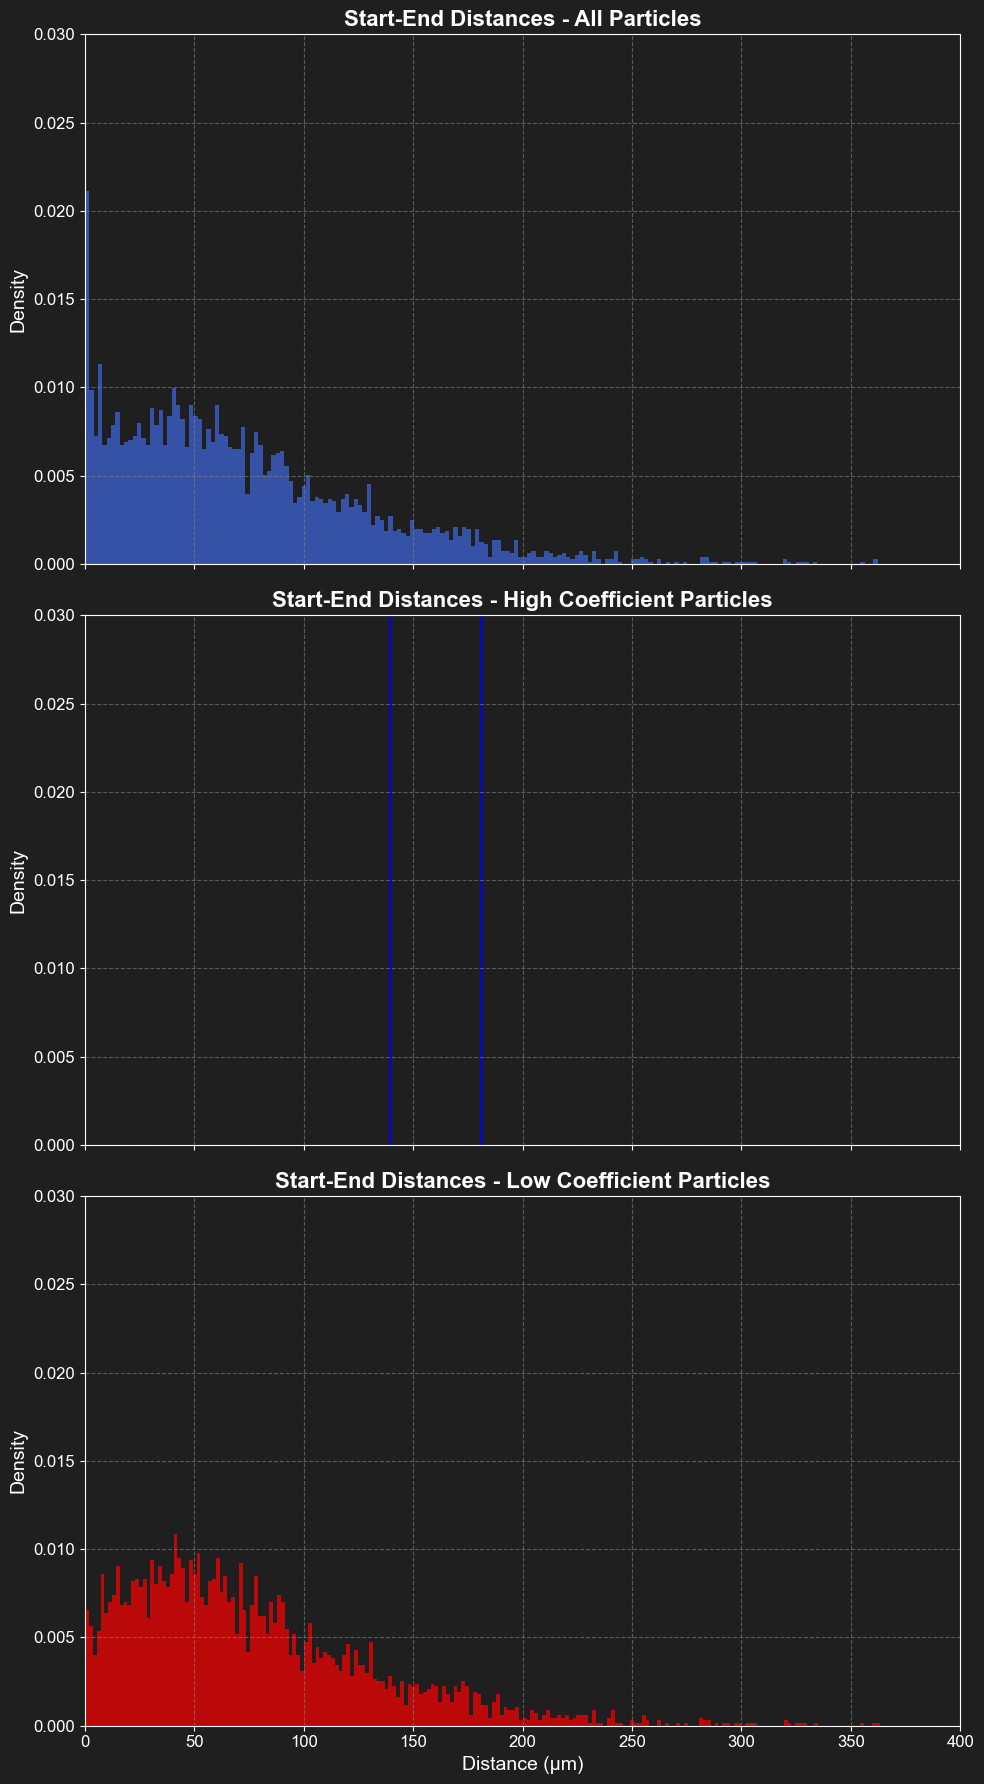

In [23]:
# Plot Histograms of Start-End Distances
def plot_histograms(start_end, PART_COEF_SUP, PART_COEF_INF):
    fig, axes = plt.subplots(3, 1, figsize=(10, 18), sharex=True, sharey=True)
    axes[0].hist(start_end, bins=250, color='royalblue', alpha=0.7, density=True)
    axes[0].set_xlim([0, 400])
    axes[0].set_title('Start-End Distances - All Particles', fontsize=16)
    axes[0].set_ylabel('Density', fontsize=14)
    axes[0].grid(True, linestyle='--', alpha=0.6)

    axes[1].hist(start_end[start_end.index.isin(PART_COEF_SUP)], bins=250, color='blue', alpha=0.7, density=True)
    axes[1].set_xlim([0, 400])
    axes[1].set_title('Start-End Distances - High Coefficient Particles', fontsize=16)
    axes[1].set_ylabel('Density', fontsize=14)
    axes[1].grid(True, linestyle='--', alpha=0.6)

    axes[2].hist(start_end[start_end.index.isin(PART_COEF_INF)], bins=250, color='red', alpha=0.7, density=True)
    axes[2].set_xlim([0, 400])
    axes[0].set_ylim([0, 0.03])
    axes[2].set_title('Start-End Distances - Low Coefficient Particles', fontsize=16)
    axes[2].set_xlabel('Distance (μm)', fontsize=14)
    axes[2].set_ylabel('Density', fontsize=14)
    axes[2].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.savefig(os.path.join(path_save_pic, f"Nstart_end inf supp and all.{IMG_TYPE}"), format=IMG_TYPE)
    plt.show()

plot_histograms(start_end, PART_COEF_SUP, PART_COEF_INF)

In [24]:
# Compute results per experiment
def compute_results(DATA, sums_df, medians):
    def get_results(exp_data):
        exp_name = exp_data['experiment'].iloc[0]
        size_y = math.ceil(exp_data['y'].max() / 2048)
        size_x = math.ceil(exp_data['x'].max() / 2048)
        taille = size_y * size_x
        nbr_particles = exp_data['particle'].nunique()
        nombre_part_par_champs = nbr_particles / taille if taille > 0 else 0
        mean_sum = sums_df[sums_df['experiment'] == exp_name]['displacement_sum'].mean()
        mean_speed = exp_data.groupby('particle')['VitInst [um/min]'].mean().mean()
        time_exp = conditions_to_values.get(exp_name, 0.0)
        median_speed = medians.get(exp_name, 0.0)
        return {
            'experiment': exp_name,
            'taille': taille,
            'nombre_part_par_champs': nombre_part_par_champs,
            'mean_sum': mean_sum,
            'mean_speed [um/min]': mean_speed,
            'time_exp [hours]': time_exp,
            'median_speed [um/min]': median_speed
        }
    result_df = DATA[DATA['frame'] < 200].groupby('experiment').apply(get_results).apply(pd.Series).reset_index(drop=True)
    return result_df

result_df = compute_results(DATA, sums_df, medians)

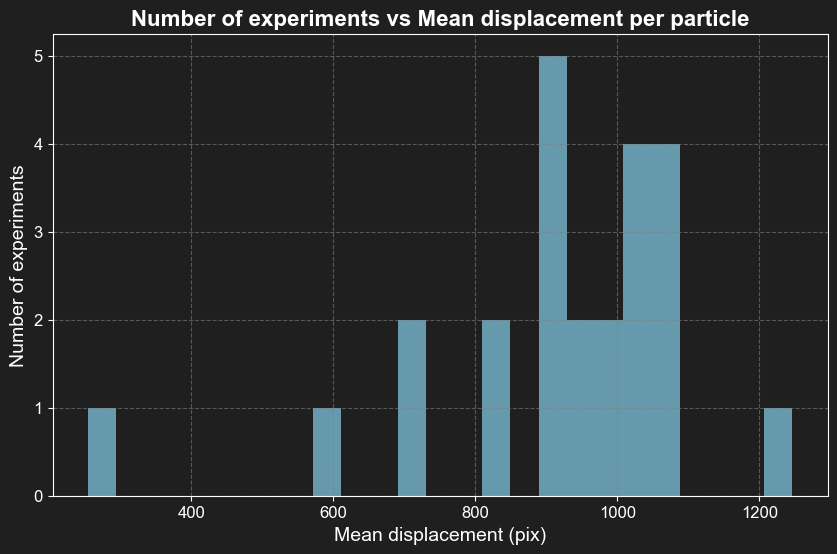

In [25]:
# Plot Histogram of Mean Displacement per Experiment
def plot_mean_displacement_histogram(mean_sum, path_save_pic, CONDITION_simple, IMG_TYPE):
    plt.figure(figsize=(10, 6))
    plt.hist(mean_sum, bins=25, color='skyblue', alpha=0.7)
    plt.title("Number of experiments vs Mean displacement per particle", fontsize=16)
    plt.xlabel("Mean displacement (pix)", fontsize=14)
    plt.ylabel("Number of experiments", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(os.path.join(path_save_pic, f"Mean_displacement_per_particle_{CONDITION_simple}.{IMG_TYPE}"), format=IMG_TYPE)
    plt.show()

mean_sum = sums_df.groupby('experiment')['displacement_sum'].mean()
plot_mean_displacement_histogram(mean_sum, path_save_pic, CONDITION_simple, IMG_TYPE)

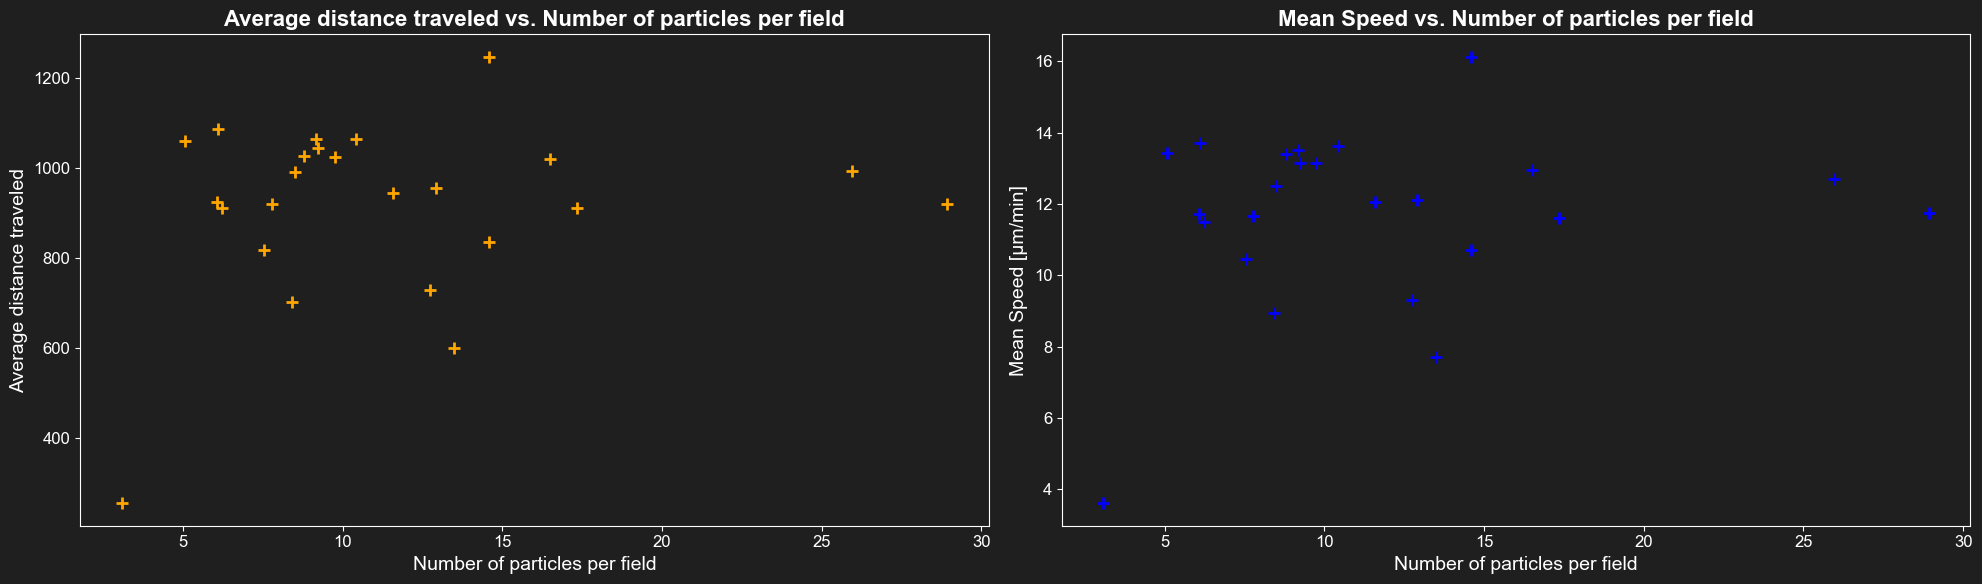

In [26]:
# Plot Results in Function of Number of Particles per Field
def plot_results_vs_particles(result_df, path_save_pic, CONDITION_simple):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    ax1, ax2 = axes.flatten()
    ax1.scatter(result_df['nombre_part_par_champs'], result_df['mean_sum'], marker='+', color='orange')
    ax1.set_title('Average distance traveled vs. Number of particles per field')
    ax1.set_xlabel('Number of particles per field')
    ax1.set_ylabel('Average distance traveled')
    ax2.scatter(result_df['nombre_part_par_champs'], result_df['mean_speed [um/min]'], marker='+', color='blue')
    ax2.set_title('Mean Speed vs. Number of particles per field')
    ax2.set_xlabel('Number of particles per field')
    ax2.set_ylabel('Mean Speed [μm/min]')
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(path_save_pic, f"Results_vs_particles_{CONDITION_simple}.png"), format='png')

plot_results_vs_particles(result_df, path_save_pic, CONDITION_simple)

In [27]:
# Compute Angle Changes between Directions
def compute_angle_changes(DATA, PART_COEF_SUP, PART_COEF_INF):
    def angle_between_directions(row):
        dx1, dy1 = row['dir_x'], row['dir_y']
        dx2, dy2 = row['dir_x_next'], row['dir_y_next']
        angle_initial = np.arctan2(dy1, dx1)
        angle_final = np.arctan2(dy2, dx2)
        angle_change = angle_final - angle_initial
        angle_change = (angle_change + np.pi) % (2 * np.pi) - np.pi
        return np.degrees(angle_change)

    df_sup = DATA[DATA['particle'].isin(PART_COEF_SUP)].copy()
    df_sup.sort_values(by=['particle', 'frame'], inplace=True)
    df_sup['dir_x'] = df_sup.groupby('particle')['x'].diff().fillna(0)
    df_sup['dir_y'] = df_sup.groupby('particle')['y'].diff().fillna(0)
    df_sup['dir_x_next'] = df_sup.groupby('particle')['dir_x'].shift(-1)
    df_sup['dir_y_next'] = df_sup.groupby('particle')['dir_y'].shift(-1)
    df_sup['angle_change'] = df_sup.apply(angle_between_directions, axis=1)
    df_sup.dropna(subset=['dir_x_next', 'dir_y_next'], inplace=True)

    df_inf = DATA[DATA['particle'].isin(PART_COEF_INF)].copy()
    df_inf.sort_values(by=['particle', 'frame'], inplace=True)
    df_inf['dir_x'] = df_inf.groupby('particle')['x'].diff().fillna(0)
    df_inf['dir_y'] = df_inf.groupby('particle')['y'].diff().fillna(0)
    df_inf['dir_x_next'] = df_inf.groupby('particle')['dir_x'].shift(-1)
    df_inf['dir_y_next'] = df_inf.groupby('particle')['dir_y'].shift(-1)
    df_inf['angle_change'] = df_inf.apply(angle_between_directions, axis=1)
    df_inf.dropna(subset=['dir_x_next', 'dir_y_next'], inplace=True)

    return df_sup, df_inf

df_sup, df_inf = compute_angle_changes(DATA, PART_COEF_SUP, PART_COEF_INF)

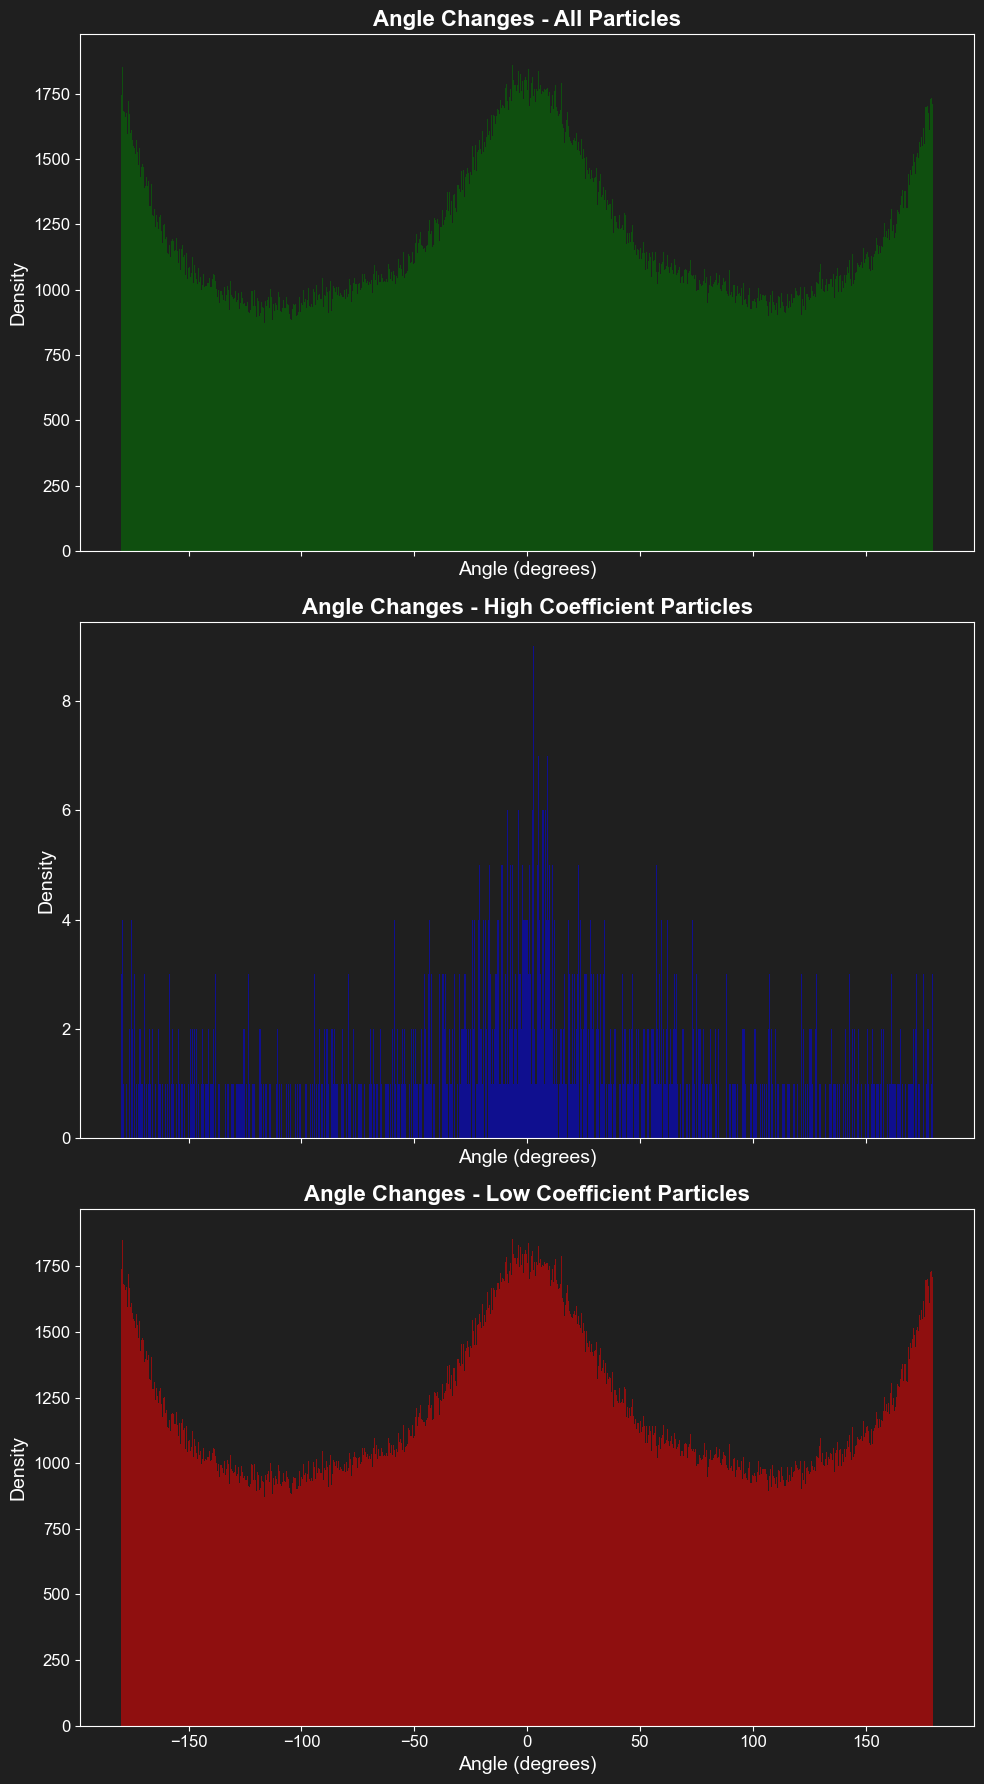

In [28]:
# Plot histograms of angle changes
def plot_angle_histograms(df_all, df_sup, df_inf):
    fig, axes = plt.subplots(3, 1, figsize=(10, 18), sharex=True)
    axes[0].hist(df_all['angle_change'], bins=1000, alpha=0.5, color='green')
    axes[0].set_title('Angle Changes - All Particles')
    axes[0].set_xlabel('Angle (degrees)')
    axes[0].set_ylabel('Density')

    axes[1].hist(df_sup['angle_change'], bins=1000, color='blue', alpha=0.5)
    axes[1].set_title('Angle Changes - High Coefficient Particles')
    axes[1].set_xlabel('Angle (degrees)')
    axes[1].set_ylabel('Density')

    axes[2].hist(df_inf['angle_change'], bins=1000, color='red', alpha=0.5)
    axes[2].set_title('Angle Changes - Low Coefficient Particles')
    axes[2].set_xlabel('Angle (degrees)')
    axes[2].set_ylabel('Density')

    plt.tight_layout()
    plt.show()
    
    fig.savefig(os.path.join(path_save_pic, 'Angle_Changes_Histograms.png'), format='png')

df_all = pd.concat([df_sup, df_inf])
plot_angle_histograms(df_all, df_sup, df_inf)

In [ ]:
# Calculate mean instantaneous velocities per particle per experiment
all_mean_vitinst = DATA.groupby(['experiment', 'particle'])['VitInst [um/min]'].mean().reset_index()

# Calculate medians of mean velocities per experiment
medians = all_mean_vitinst.groupby('experiment')['VitInst [um/min]'].median()

# Plot histograms of mean velocities per experiment, sorted by incubation time
from matplotlib import colormaps

def plot_velocity_histograms(all_mean_vitinst, medians, exp_hours, path_save_pic, img_type):
    """
    Plot histograms of mean instantaneous velocities for each experiment, sorted by incubation time.

    Parameters:
    - all_mean_vitinst (DataFrame): DataFrame containing mean velocities per particle and experiment.
    - medians (Series): Median velocities for each experiment.
    - exp_hours (DataFrame): DataFrame with experiments and their corresponding incubation times.
    - path_save_pic (str): Path where the plot will be saved.
    """
    # Sort experiments by incubation time
    exp_hours = exp_hours.sort_values(by='time to incubation (hours)').reset_index(drop=True)
    experiments = exp_hours['experiment'].tolist()
    incubation_times = exp_hours['time to incubation (hours)'].tolist()

    # Calculate global limits for better visualization
    global_min = all_mean_vitinst['VitInst [um/min]'].min()
    global_max = all_mean_vitinst['VitInst [um/min]'].max()
    delta = (global_max - global_min) * 0.1  # Add 10% padding to the range
    global_min -= delta
    global_max += delta

    # Prepare the figure and subplots
    n_experiments = len(experiments)
    fig, axes = plt.subplots(nrows=n_experiments, ncols=1, figsize=(10, 3 * n_experiments), sharex=True, sharey=True)

    # Ensure 'axes' is a list even if there's only one subplot
    if n_experiments == 1:
        axes = [axes]

    # Generate a color palette
    palette = colormaps['tab20']  # Updated to use colormaps
    colors = [palette(i / n_experiments) for i in range(n_experiments)]  # Normalize indices to [0, 1]

    # Iterate over each experiment
    for idx, ax in enumerate(axes):
        exp = experiments[idx]
        hour = incubation_times[idx]

        # Select data for the current experiment
        data_exp = all_mean_vitinst[all_mean_vitinst['experiment'] == exp]

        # Plot the histogram
        ax.hist(
            data_exp['VitInst [um/min]'],
            bins=30,
            alpha=0.3,
            range=(global_min, global_max),
            color=colors[idx]
        )
        ax.set_title(f'Vit. Inst. Moyenne [μm/min] - {exp} (Incubation: {hour}h)')
        ax.set_xlabel('VitInst [μm/min]')
        ax.set_ylabel('Nombre de particules')

        # Add the median line and annotation
        median_value = medians.loc[exp]
        ax.axvline(median_value, color='red', linestyle='dashed', linewidth=1)
        ax.text(
            median_value + 0.05 * (global_max - global_min),  # Offset for the annotation
            ax.get_ylim()[1] * 0.95,
            f'Médiane: {median_value:.2f}',
            color='red',
            ha='left'
        )

        # Apply uniform x-axis limits
        ax.set_xlim(global_min, global_max)

    # Adjust layout to avoid overlap
    plt.tight_layout()

    # Save the figure
    fig_path = os.path.join(path_save_pic, f'Velocity_Histograms.{img_type}')
    fig.savefig(fig_path, format=img_type)

    # Show the figure
    plt.show()

    print(f"Plot saved to {fig_path}")
    
plot_velocity_histograms(all_mean_vitinst, medians, exp_hours, path_save_pic, IMG_TYPE)

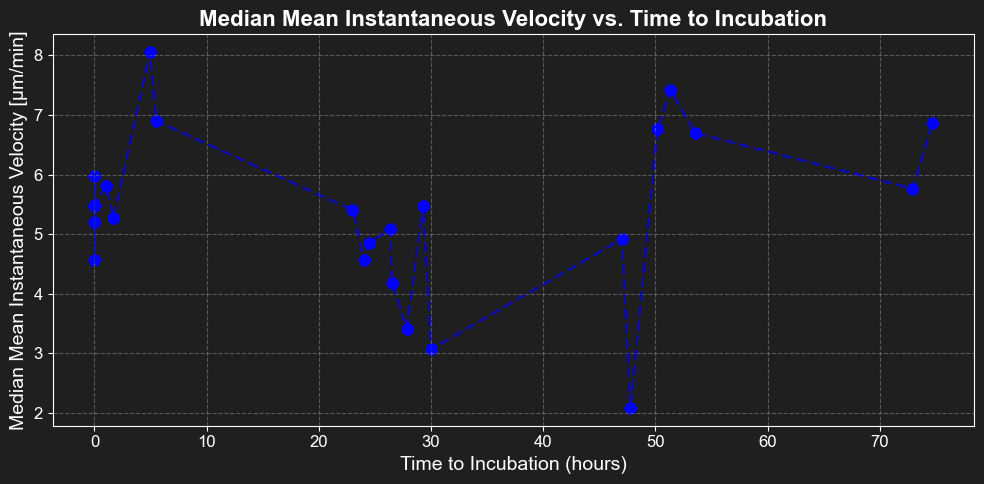

<Figure size 640x480 with 0 Axes>

In [30]:
# Plot median velocities as a function of incubation time
def plot_median_velocity_vs_time(result_df, path_save_pic):
    result_df_sorted = result_df.sort_values(by='time_exp [hours]')
    plt.figure(figsize=(10, 5))
    plt.scatter(result_df_sorted['time_exp [hours]'], result_df_sorted['median_speed [um/min]'], color='blue')
    plt.plot(result_df_sorted['time_exp [hours]'], result_df_sorted['median_speed [um/min]'], linestyle='--', color='blue', alpha=0.6)
    plt.title('Median Mean Instantaneous Velocity vs. Time to Incubation')
    plt.xlabel('Time to Incubation (hours)')
    plt.ylabel('Median Mean Instantaneous Velocity [μm/min]')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(path_save_pic, 'Median_Velocity_vs_Time.png'), format='png')

plot_median_velocity_vs_time(result_df, path_save_pic)

In [31]:
pd.concat([df_inf['experiment'], df_sup['experiment']]).nunique()

24

In [32]:
def compute_particle_proportions(df_inf, df_sup, DATA):
    # Créer une base de données contenant toutes les expériences de DATA
    all_experiments = DATA['experiment'].unique()

    # Nombre de particules dans df_inf et df_sup
    unique_particles_inf = df_inf.groupby('experiment')['particle'].nunique().rename('inf')
    unique_particles_sup = df_sup.groupby('experiment')['particle'].nunique().rename('sup')

    # Créer un DataFrame avec toutes les expériences, en initialisant à 0 si une expérience est absente
    unique_particles = pd.DataFrame(index=all_experiments)
    unique_particles = unique_particles.join(unique_particles_inf, how='left').join(unique_particles_sup, how='left')
    unique_particles = unique_particles.fillna(0)  # Remplir les valeurs manquantes avec 0

    # Calculer la proportion de particules "inf"
    unique_particles['proportion_inf'] = unique_particles['inf'] / (unique_particles['inf'] + unique_particles['sup'])

    # Ajouter la colonne 'time_to_incubation' depuis DATA (en utilisant les premières valeurs par expérience)
    time_to_incubation = DATA.groupby('experiment')['time to incubation (hours)'].first()
    unique_particles['time_to_incubation'] = time_to_incubation

    # Trier par 'time_to_incubation' tout en gardant les NaN si nécessaire
    unique_particles = unique_particles.sort_values('time_to_incubation', na_position='last')

    return unique_particles

unique_particles = compute_particle_proportions(df_inf, df_sup, DATA)

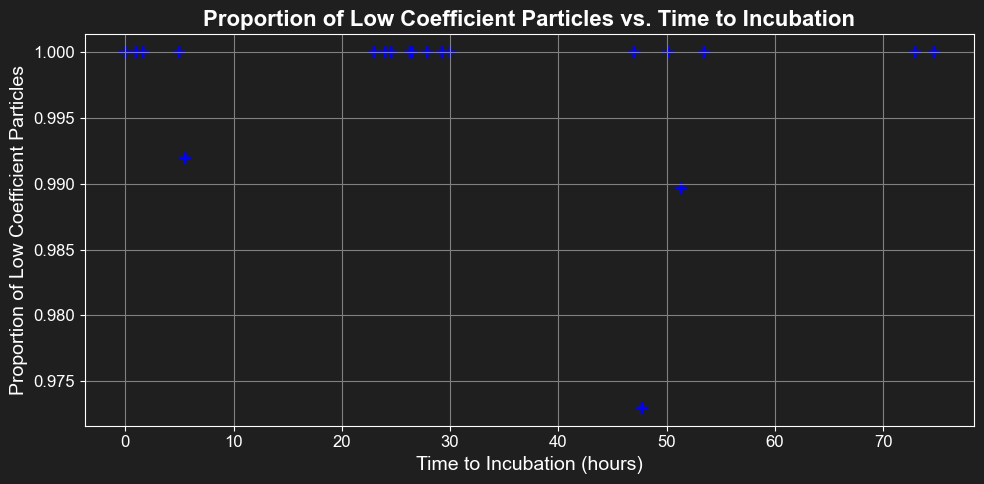

<Figure size 640x480 with 0 Axes>

In [33]:

# Plot proportion of 'df_inf' particles vs. time to incubation
def plot_proportion_vs_time(unique_particles, path_save_pic, img_type):
    plt.figure(figsize=(10, 5))
    plt.scatter(unique_particles['time_to_incubation'], unique_particles['proportion_inf'], color='blue', marker='+')
    plt.title('Proportion of Low Coefficient Particles vs. Time to Incubation')
    plt.xlabel('Time to Incubation (hours)')
    plt.ylabel('Proportion of Low Coefficient Particles')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(path_save_pic, f'Proportion_Low_Coeff_Particles_vs_Time.{img_type}'), format=img_type)

plot_proportion_vs_time(unique_particles, path_save_pic, IMG_TYPE)

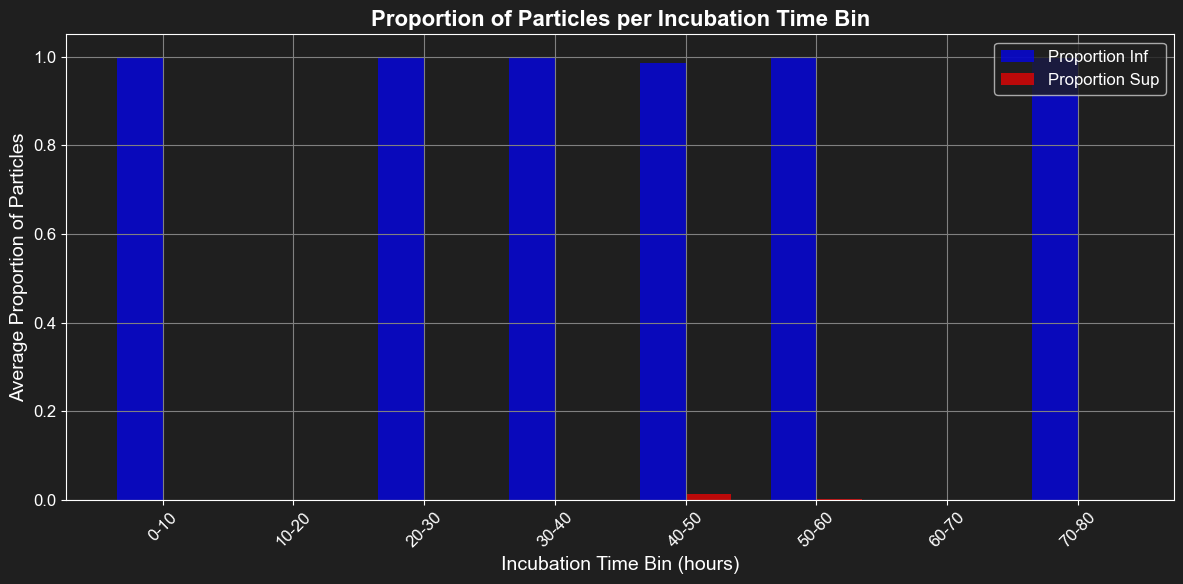

In [34]:
# Plot proportions per incubation time bins
def plot_proportion_per_time_bins(unique_particles, path_save_pic, img_type):
    bins = np.arange(0, unique_particles['time_to_incubation'].max() + 10, 10)
    labels = [f"{int(left)}-{int(right)}" for left, right in zip(bins[:-1], bins[1:])]
    unique_particles['time_bin'] = pd.cut(unique_particles['time_to_incubation'], bins=bins, labels=labels, right=False)
    proportion_per_bin_inf = unique_particles.groupby('time_bin', observed=False)['proportion_inf'].mean()
    proportion_per_bin_sup = 1 - proportion_per_bin_inf

    x = np.arange(len(proportion_per_bin_inf))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, proportion_per_bin_inf, width, color='blue', alpha=0.7, label='Proportion Inf')
    ax.bar(x + width/2, proportion_per_bin_sup, width, color='red', alpha=0.7, label='Proportion Sup')
    ax.set_title('Proportion of Particles per Incubation Time Bin')
    ax.set_xlabel('Incubation Time Bin (hours)')
    ax.set_ylabel('Average Proportion of Particles')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(path_save_pic, f'Proportion_vs_Time_Bins.{img_type}'), format=img_type)

plot_proportion_per_time_bins(unique_particles, path_save_pic, IMG_TYPE)

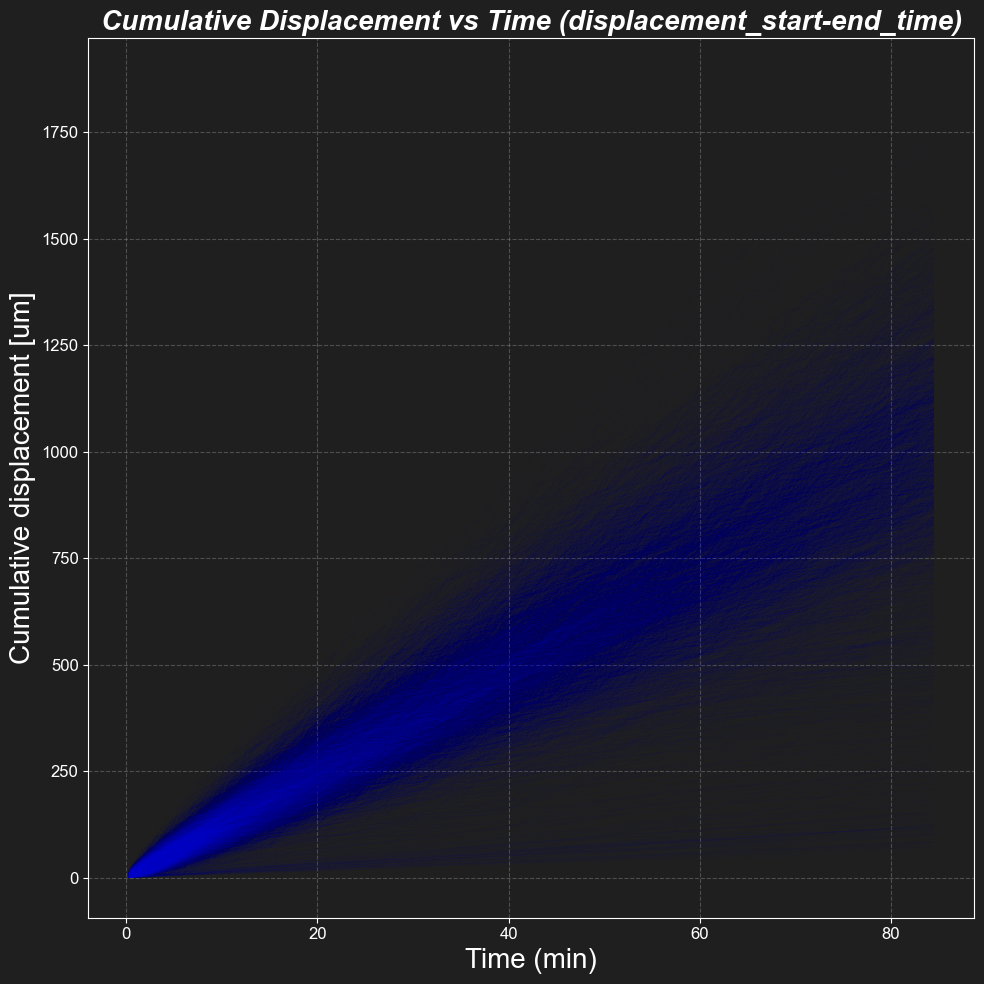

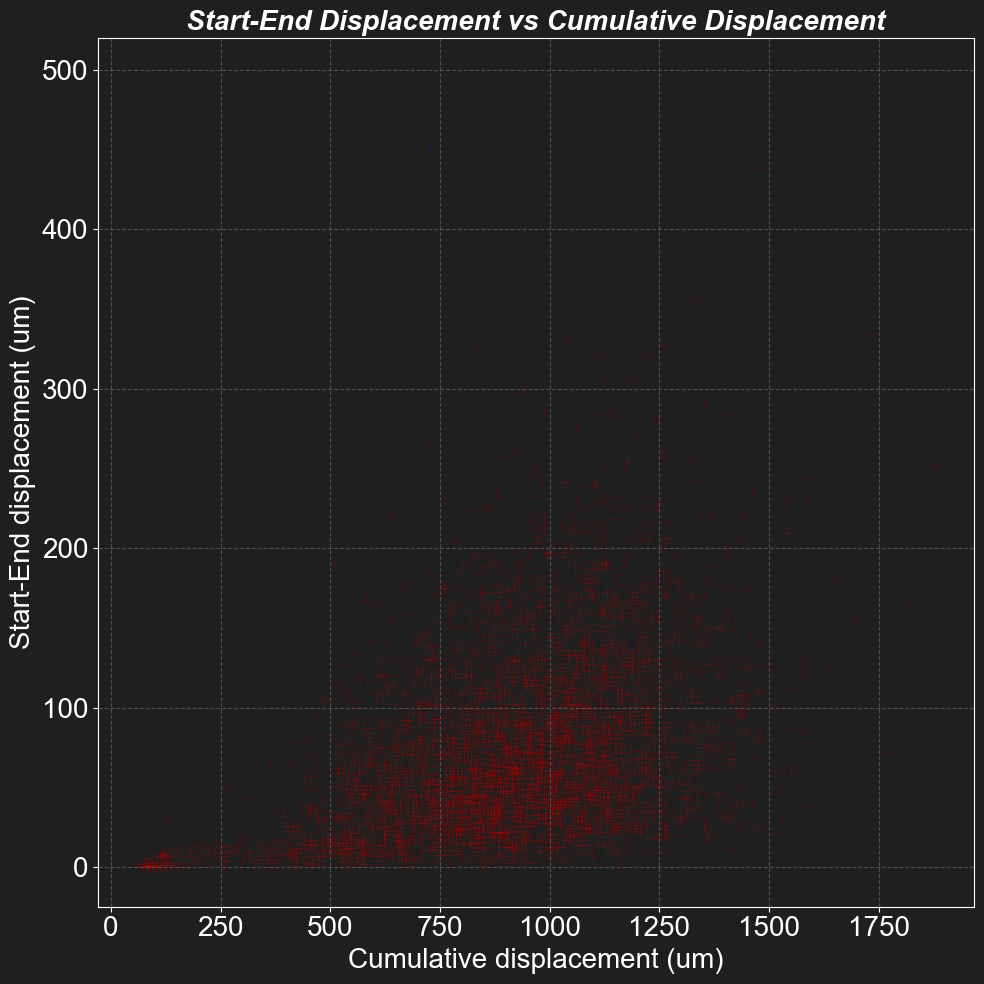

In [43]:
# Plot displacement comparison between low and high coefficient particles
lib.plot_displacement_low_and_high(
    traj_sup=df_sup,
    traj_inf=df_inf,
    part_coef_inf=PART_COEF_INF,
    part_coef_sup=PART_COEF_SUP,
    start_end=start_end,
    save=True,
    pathway_saving=path_save_pic,
    name="displacement_start-end_time",
    img_type=IMG_TYPE
)

Il y'a plusieurs choses qui ne vont pas : Les temps Nan dans unique particles, n'ont pas de sens. Il y'a des endroits ou on ne prends pas en compte les manips au temps 0. 


df_inf est pas complet pour calculer les unique_...

In [44]:
DATA[DATA['experiment']== 'ASMOT184'].shape[0]

22863

In [45]:
sums_df

experiment  particle  displacement_sum
0      ASMOT184       856        732.265143
1      ASMOT184       857        630.572624
2      ASMOT184       858       1310.882345
3      ASMOT184       859        888.315452
4      ASMOT184       860        151.498850
...         ...       ...               ...
3835   ASMOT209      3663       1169.569229
3836   ASMOT209      3665       1052.120574
3837   ASMOT209      3666        811.062165
3838   ASMOT209      3667       1156.655473
3839   ASMOT209      3668       1306.143275

[3840 rows x 3 columns]

In [46]:
medians

experiment
ASMOT184    13.189734
ASMOT185    11.143724
ASMOT186    12.400465
ASMOT187    10.643879
ASMOT188     9.317834
ASMOT189     6.309220
ASMOT190     3.049744
ASMOT191    13.753302
ASMOT192    13.010539
ASMOT194    13.226243
ASMOT196    11.706644
ASMOT197    13.609119
ASMOT198    12.240964
ASMOT199    14.367697
ASMOT200    13.311018
ASMOT201    12.745518
ASMOT202    11.383057
ASMOT203    11.892073
ASMOT204     7.793820
ASMOT205    12.413157
ASMOT206    11.406874
ASMOT207    12.512909
ASMOT208    12.077011
ASMOT209    14.015637
Name: VitInst [um/min], dtype: float64